In [31]:
"""
till now makemore has been a MLP arch which is quite basic.

complex arch:
- take more chars than 3
- don't just feed them to a single hidden layer. single hidden layer squashes a lot of info quickly.
- instead make a deeper model that progressively fuses the knowledge to make the next char guess.
- this arch is called wavenet.

"""

"\ntill now makemore has been a MLP arch which is quite basic.\n\ncomplex arch:\n- take more chars than 3\n- don't just feed them to a single hidden layer. single hidden layer squashes a lot of info quickly.\n- instead make a deeper model that progressively fuses the knowledge to make the next char guess.\n- this arch is called wavenet.\n\n"

In [32]:
import torch

import torch.nn.functional as F
import matplotlib.pyplot as plt

%matplotlib inline

In [33]:
words = open("names.txt", "r").read().splitlines()
print(len(words))
print(max(map(len, words)))
words[:8]

32033
15


['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [34]:
# build vocab
chars = list(sorted(set("".join(words))))
stoi = {s: i for i, s in enumerate(["."] + chars)}
itos = {i: s for s, i in stoi.items()}
vocab_size = len(itos)

print(itos)
print(vocab_size)

{0: '.', 1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z'}
27


In [35]:
import random

random.seed(42)
random.shuffle(words)

In [36]:
block_size = 8


def build_dataset(_words):
    X, Y = [], []
    for w in _words[:]:
        # print(w)
        context = [0] * block_size

        for ch in w + ".":
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join(itos[i] for i in context), "--->", itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)

    print(X.shape, Y.shape)
    return X, Y


n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [37]:
for x, y in zip(Xtr[:20], Ytr[:20]):
    print("".join(itos[ix.item()] for ix in x), "-->", itos[y.item()])

........ --> y
.......y --> u
......yu --> h
.....yuh --> e
....yuhe --> n
...yuhen --> g
..yuheng --> .
........ --> d
.......d --> i
......di --> o
.....dio --> n
....dion --> d
...diond --> r
..diondr --> e
.diondre --> .
........ --> x
.......x --> a
......xa --> v
.....xav --> i
....xavi --> e


In [38]:
class Linear:
    def __init__(self, fan_in, fan_out, bias=True):
        # there are fan_out number of neurons.
        # every neuron has fan_in number of weights.
        self.weight = torch.randn((fan_in, fan_out)) / (fan_in**0.5)
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # params (training with backprop)
        self.gamma = torch.ones(dim)  # gain
        self.beta = torch.zeros(dim)  # bias
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)

    def __call__(self, x):
        # forward pass
        if self.training:
            if x.ndim == 2:
                # first dim is the number of iterations
                # second dim is the actual inputs
                dim = 0
            elif x.ndim == 3:
                # first dim is number of iterations
                # second dim is number of sequences cuz input is broken up
                dim = (0, 1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
        else:
            xmean = self.running_mean
            xvar = self.running_var

        xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
        self.out = self.gamma * xhat + self.beta

        if self.training:
            with torch.no_grad():
                self.running_mean = (
                    1 - self.momentum
                ) * self.running_mean + self.momentum * xmean
                self.running_var = (
                    1 - self.momentum
                ) * self.running_var + self.momentum * xvar

        return self.out

    def parameters(self):
        return [self.gamma, self.beta]


class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out

    def parameters(self):
        return []


class Embedding:
    def __init__(self, num_embeddings, embedding_dim):
        self.weight = torch.randn((num_embeddings, embedding_dim))

    def __call__(self, IX):
        self.out = self.weight[IX]
        return self.out

    def parameters(self):
        return [self.weight]


class FlattenConsecutive:
    def __init__(self, n):
        # how many consec chars to flatten
        self.n = n

    def __call__(self, x):
        B, T, C = x.shape
        x = x.view(B, T // self.n, C * self.n)  # can replace T // n with -1 as well

        # in case everything from the input vector is concatenated,
        # then the mid vector becomes 1.
        # in such case, let's squeeze it out for hygiene.
        if x.shape[1] == 1:
            x = x.squeeze(1)
        self.out = x
        return self.out

    def parameters(self):
        return []


class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        self.out = x
        return self.out

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

In [39]:
torch.manual_seed(42)

In [47]:
n_embed = 24
n_hidden = 128

model = Sequential(
    [
        Embedding(vocab_size, n_embed),
        FlattenConsecutive(2),
        Linear(n_embed * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        FlattenConsecutive(2),
        Linear(n_hidden * 2, n_hidden, bias=False),
        BatchNorm1d(n_hidden),
        Tanh(),
        Linear(n_hidden, vocab_size),
    ]
)

with torch.no_grad():
    model.layers[-1].weight *= 0.1

parameters = model.parameters()

print(sum(p.nelement() for p in parameters))

for p in parameters:
    p.requires_grad = True

76579


In [46]:
for layer in model.layers:
    print(layer.__class__.__name__, ":", tuple(layer.out.shape))

"""
explanation:

there are 32 iterations. explanation is per iteration.

Embedding : (32, 8, 10) -> 8 embeddings, 10 points / char
FlattenConsecutive : (32, 4, 20) -> group consecutive pairs. 4 pairs, 20 points / pair

Linear : (32, 4, 68) -> 
this is like 4 iterations now unlike the 8 iterations earlier through this layer. hence,
output can be interpreted as [h1, h2, h3, h4]

BatchNorm1d : (32, 4, 68) -> mean over all 4 sequences / iteration.
...
...
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)
"""

Embedding : (32, 8, 10)
FlattenConsecutive : (32, 4, 20)
Linear : (32, 4, 68)
BatchNorm1d : (32, 4, 68)
Tanh : (32, 4, 68)
FlattenConsecutive : (32, 2, 136)
Linear : (32, 2, 68)
BatchNorm1d : (32, 2, 68)
Tanh : (32, 2, 68)
FlattenConsecutive : (32, 136)
Linear : (32, 68)
BatchNorm1d : (32, 68)
Tanh : (32, 68)
Linear : (32, 27)


In [48]:
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
    ix = torch.randint(0, Xtr.shape[0], (batch_size,))
    Xb, Yb = Xtr[ix], Ytr[ix]

    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 150_000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10_000 == 0:
        print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
    lossi.append(loss.log10().item())

      0/ 200000: 3.3001
  10000/ 200000: 1.8787
  20000/ 200000: 1.8376
  30000/ 200000: 2.1346
  40000/ 200000: 2.2899
  50000/ 200000: 2.3220
  60000/ 200000: 2.1495
  70000/ 200000: 2.2347
  80000/ 200000: 1.9030
  90000/ 200000: 1.8326
 100000/ 200000: 1.9834
 110000/ 200000: 2.4457
 120000/ 200000: 2.0388
 130000/ 200000: 2.0802
 140000/ 200000: 2.1505
 150000/ 200000: 1.9460
 160000/ 200000: 1.6511
 170000/ 200000: 1.5040
 180000/ 200000: 1.9012
 190000/ 200000: 1.7759


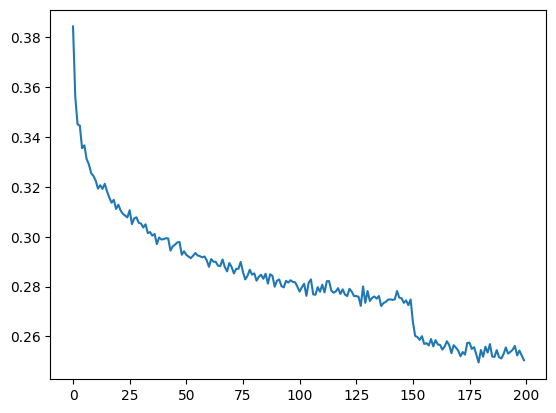

In [49]:
# arrange loss into chunks of 1000. generate 200 means & visualise the
# learning rate decay.
# this visual performs conveys better info than
# plt.plot(lossi)
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))

In [50]:
for layer in model.layers:
    layer.training = False

In [51]:
@torch.no_grad  # disable gradient tracking
def split_loss(split):
    x, y = {"train": (Xtr, Ytr), "val": (Xdev, Ydev), "test": (Xte, Yte)}[split]

    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())


split_loss("train")
split_loss("val")

train 1.766514539718628
val 1.9915895462036133


#### perf log
- original (3 char context + 200 hidden neurons, 12k params): train: 2.058, val: 2.105
- context 3 -> 8 (22k params): train: 1.918, val: 2.023
- per is much better. larger wavenet has been implemented now. train: 1.767 val: 1.992

In [52]:
for _ in range(40):
    out = []
    context = [0] * block_size

    while True:
        logits = model(torch.tensor([context]))
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1).item()
        context = context[1:] + [ix]
        out.append(ix)

        if ix == 0:
            break

    print("".join(itos[i] for i in out))

gwendolynn.
yanah.
caneur.
emilia.
oluwadove.
kontara.
zarria.
lona.
naji.
alystaa.
bezzey.
amiryaga.
rubhier.
ayaansh.
cerell.
elanora.
jasiyah.
brextin.
amori.
milla.
sajah.
violejanesuin.
annyiah.
haydin.
romina.
ryon.
saarukaj.
ahavan.
aivah.
miassi.
darjay.
winn.
caldana.
audreana.
jamaeya.
evelangelu.
trustyn.
maryora.
joelis.
rufynn.
